In [1]:
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(tidytext)

In [3]:
library(wordcloud)

Loading required package: RColorBrewer


In [4]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [5]:
list.files(path = getwd(), pattern = "txt")

[1] "20190911-entrevista_bbc-texto-texto.txt"
[2] "20190911-entrevista_bbc-video.txt"      
[3] "20190911-entrevista_elpais-texto.txt"   
[4] "20190911-entrevista_emol-texto.txt"     
[5] "20190911-entrevista-fuentes.txt"

In [6]:
textos <- list.files(path = getwd(), pattern = "*texto.txt")

In [7]:
textos

[1] "20190911-entrevista_bbc-texto-texto.txt"
[2] "20190911-entrevista_elpais-texto.txt"   
[3] "20190911-entrevista_emol-texto.txt"

In [8]:
num_files <- length(textos)

In [9]:
dfs <- paste("df", seq(1:num_files), collapse = NULL, sep = "_")
qsts <- paste("qst", seq(1:num_files), collapse = NULL, sep = "_")
tibs <- paste("tib", seq(1:num_files), collapse = NULL, sep = "_")

In [10]:
for(i in seq(1:num_files)){
    filepath <- paste0(getwd(), "/", textos[i])
    tmp <- read.delim(file = filepath, sep = "\n", header = FALSE)
    tmp$typeline <- substring(tmp[, 1], 1, 1)
    tmp$source <- textos[i]
    tmp[, 1] <- gsub("Q:|A:", "", tmp[, 1])
    assign(dfs[i], tmp)
    tmp <- eval(parse(text = dfs[i]))
    tmp <- subset(tmp, typeline == "Q")
    assign(qsts[i], tmp)
    print(paste0("Tipos de línea en el texto: ", unique(eval(parse(text = qsts[i]))$typeline)))
}

[1] "Tipos de línea en el texto: Q"
[1] "Tipos de línea en el texto: Q"
[1] "Tipos de línea en el texto: Q"


In [11]:
cols_to_select <- c("text", "line", "source")

In [12]:
cleanText <- function(x){
  x <- chartr("áéíóú", "aeiou", x)
  x <- gsub("\r?\n|\r|\t", " ", x)
  x <- gsub("[ |\t]{2,}", " ", x)
  x <- gsub("^ ", "", x)
  x <- gsub(" $", "", x)
  x <- gsub("<", "", x)
  x <- gsub(">", "", x)
  x <- gsub("[[:punct:]]", " ", x)
  x <- gsub("[[:digit:]]", " ", x)
  x <- gsub("(?<=[\\s])\\s*|^\\s+|\\s+$", " ", x, perl=TRUE)
}

In [13]:
tibble_1 <- tibble(text = cleanText(qst_1$V1), typeline = qst_1$typeline, line = seq(1:nrow(qst_1)), source = qst_1$source) %>% select(cols_to_select)
tibble_2 <- tibble(text = cleanText(qst_2$V1), typeline = qst_2$typeline, line = seq(1:nrow(qst_2)), source = qst_2$source) %>% select(cols_to_select)
tibble_3 <- tibble(text = cleanText(qst_3$V1), typeline = qst_3$typeline, line = seq(1:nrow(qst_3)), source = qst_3$source) %>% select(cols_to_select)

In [14]:
custom_stop_words <- rbind(tibble(word = tm::stopwords("spanish"), lexicon = "custom"),
                           tibble(word = c("usted", "de", "la", "un", "y"), lexicon = "custom"))

In [15]:
tokenized_1 <- tibble_1 %>% unnest_tokens(word, text) %>% anti_join(custom_stop_words)
tokenized_2 <- tibble_2 %>% unnest_tokens(word, text) %>% anti_join(custom_stop_words)
tokenized_3 <- tibble_3 %>% unnest_tokens(word, text) %>% anti_join(custom_stop_words)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


In [16]:
tokenized_total <- rbind(tokenized_1, tokenized_2, tokenized_3)

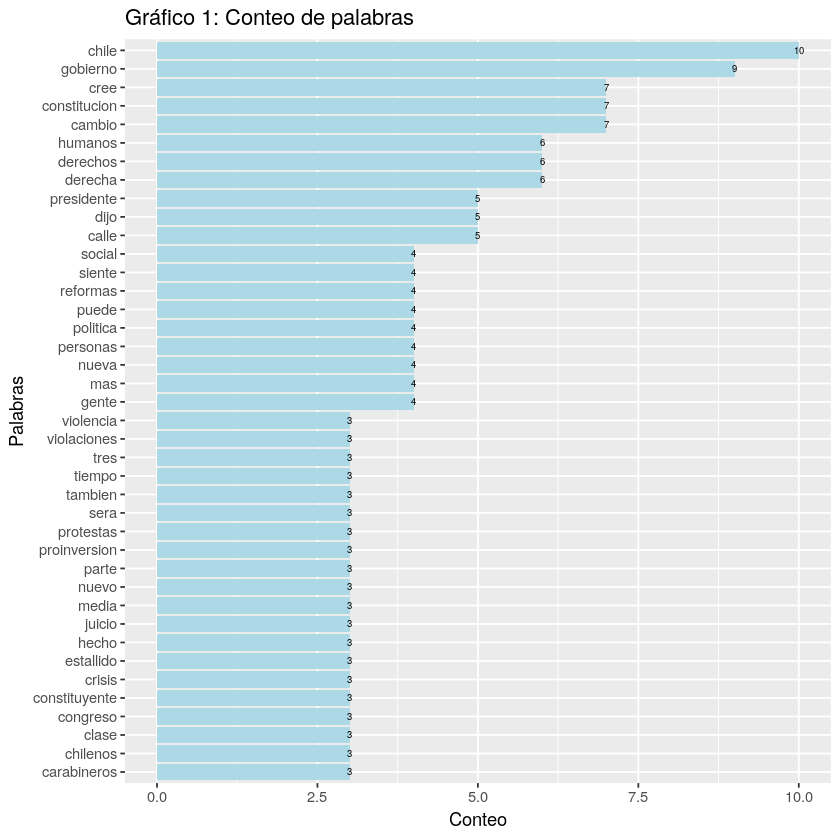

In [17]:
tokenized_total %>%
    count(word, sort = TRUE) %>%
    filter(n > 2) %>%
    mutate(word = reorder(word, n)) %>%
    ggplot(aes(x = word, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    geom_text(size = 2) + 
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip() +
    ggtitle("Gráfico 1: Conteo de palabras")

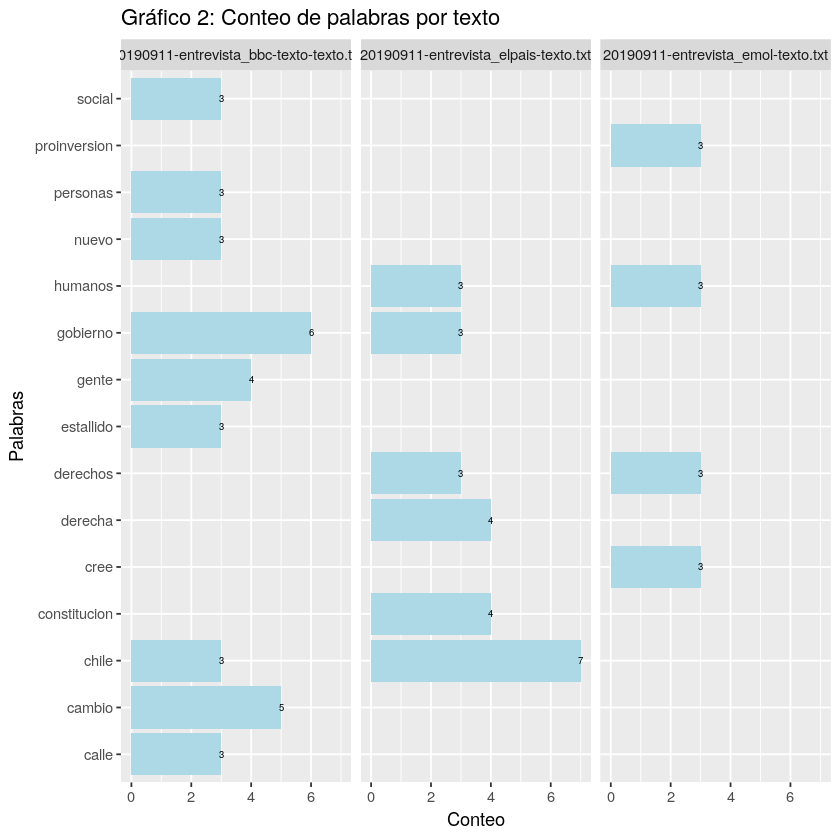

In [18]:
tokenized_total %>%
    count(source, word) %>%
    group_by(source) %>%
    filter(n > 2) %>%
    ggplot(aes(x = word, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    geom_text(size = 2) + 
    facet_wrap(~ source) +
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip() +
    ggtitle("Gráfico 2: Conteo de palabras por texto")

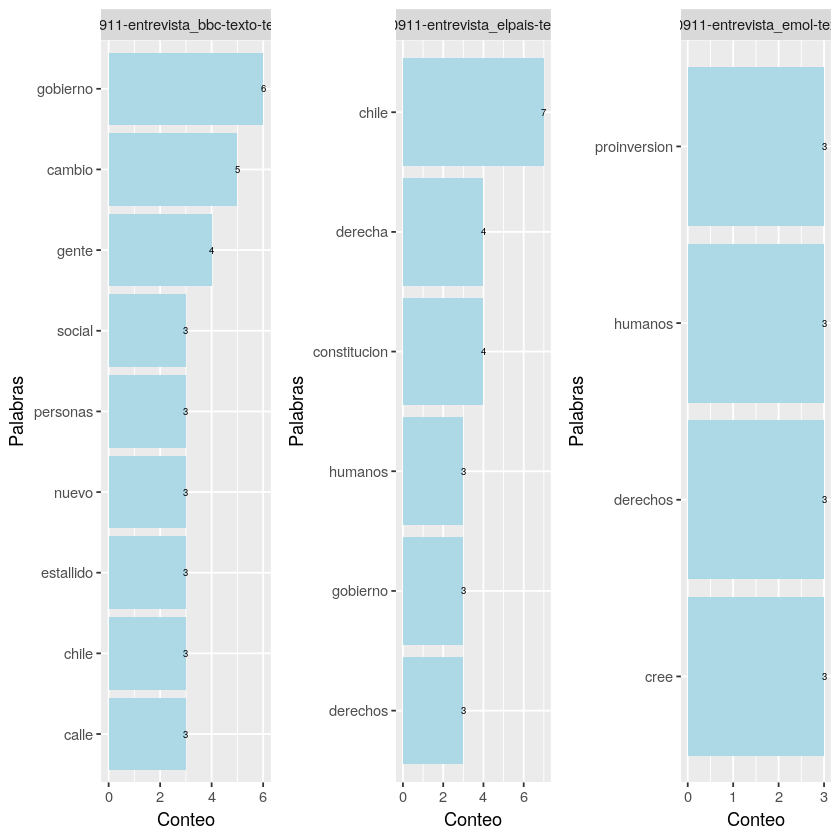

In [27]:
p1 <- tokenized_1 %>%
    count(source, word) %>%
    filter(n > 2) %>%
    mutate(word = reorder(word, n)) %>%
    ggplot(aes(x = word, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    geom_text(size = 2) +
    facet_wrap(~source) +
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip()

p2 <- tokenized_2 %>%
    count(source, word) %>%
    filter(n > 2) %>%
    mutate(word = reorder(word, n)) %>%
    ggplot(aes(x = word, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    geom_text(size = 2) +
    facet_wrap(~source) +
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip()

p3 <- tokenized_3 %>%
    count(source, word) %>%
    filter(n > 2) %>%
    mutate(word = reorder(word, n)) %>%
    ggplot(aes(x = word, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    geom_text(size = 2) +
    facet_wrap(~source) +
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip()

multiplot(p1, p2, p3, cols =3)

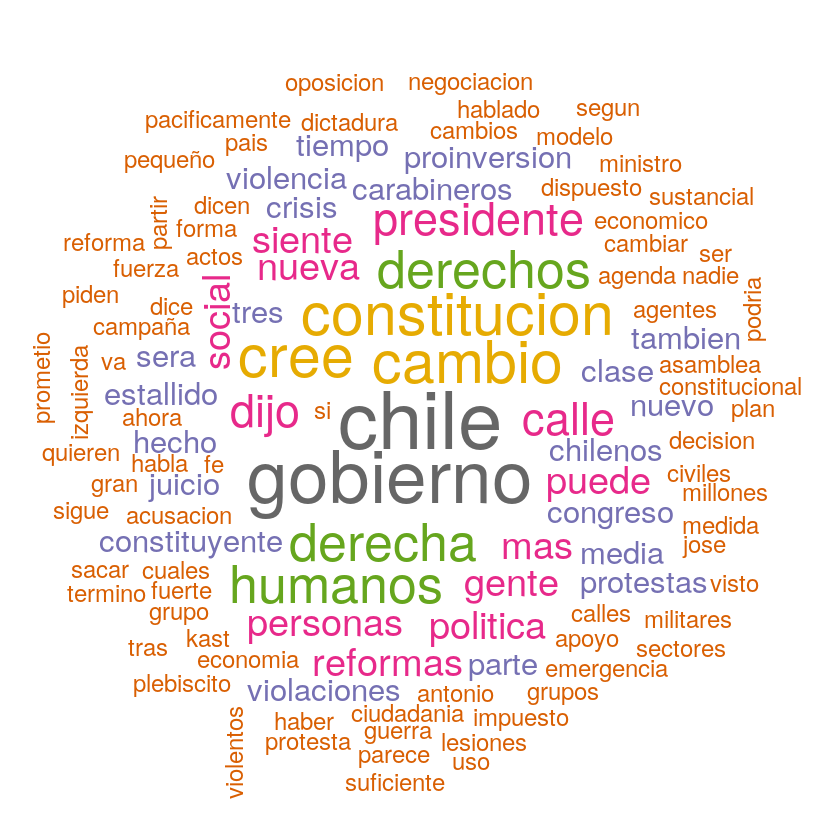

In [20]:
tokenized_total %>%
    count(word) %>%
    mutate(word = reorder(word, n)) %>%
    with(wordcloud(words = word, freq = n, min.freq = 2, random.order = FALSE, colors = brewer.pal(8, "Dark2")))

In [21]:
ngram_1 <- tibble_1 %>% 
    unnest_tokens(ngram, text, token = "ngrams", n = 2) %>% 
    separate(ngram, c("w1", "w2"), sep = " ") %>%
    filter(!w1 %in% custom_stop_words$word) %>%
    filter(!w2 %in% custom_stop_words$word) %>%
    unite(ngram, w1, w2, sep = " ")

ngram_2 <- tibble_2 %>% 
    unnest_tokens(ngram, text, token = "ngrams", n = 2) %>% 
    separate(ngram, c("w1", "w2"), sep = " ") %>%
    filter(!w1 %in% custom_stop_words$word) %>%
    filter(!w2 %in% custom_stop_words$word) %>%
    unite(ngram, w1, w2, sep = " ")

ngram_3 <- tibble_3 %>% 
    unnest_tokens(ngram, text, token = "ngrams", n = 2) %>% 
    separate(ngram, c("w1", "w2"), sep = " ") %>%
    filter(!w1 %in% custom_stop_words$word) %>%
    filter(!w2 %in% custom_stop_words$word) %>%
    unite(ngram, w1, w2, sep = " ")

In [22]:
ngram_t <- rbind(ngram_1, ngram_2, ngram_3)

Selecting by tf_idf


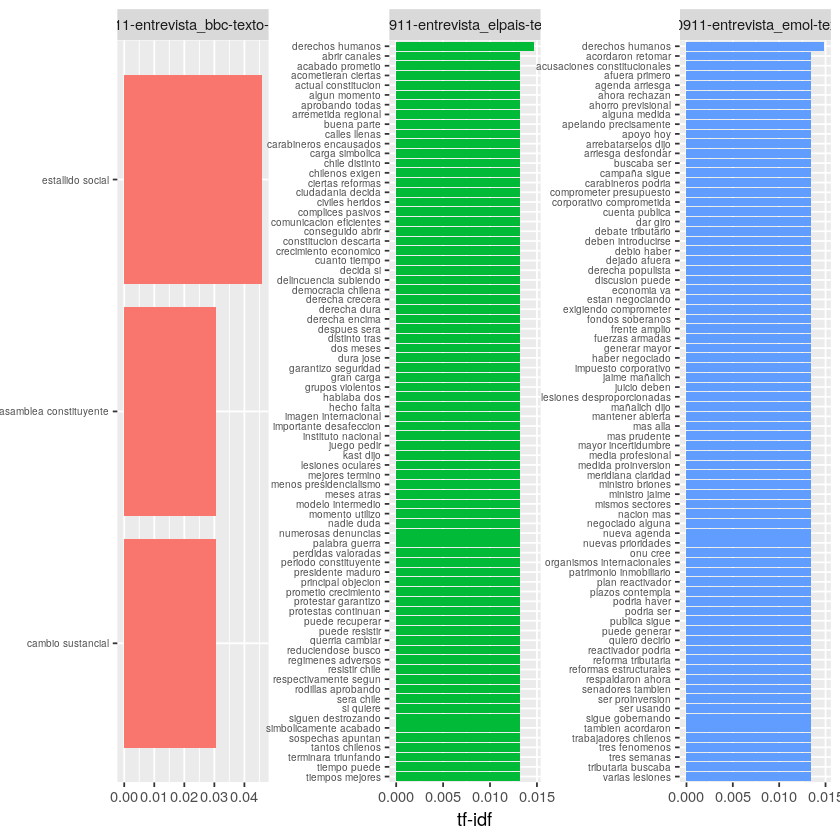

In [23]:
tdidf <- ngram_t %>%
    count(source, ngram) %>%
    bind_tf_idf(ngram, source, n) %>%
    arrange(desc(tf_idf))

tdidf %>%
  arrange(desc(tf_idf)) %>%
  mutate(ngram = factor(ngram, levels = rev(unique(ngram)))) %>% 
  group_by(source) %>% 
  top_n(3) %>% 
  ungroup() %>%
  ggplot(aes(ngram, tf_idf, fill = source)) +
  geom_col(show.legend = FALSE) +
  theme(axis.text.y = element_text(size = 6)) + 
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~source, ncol = 3, scales = "free") +
  coord_flip()

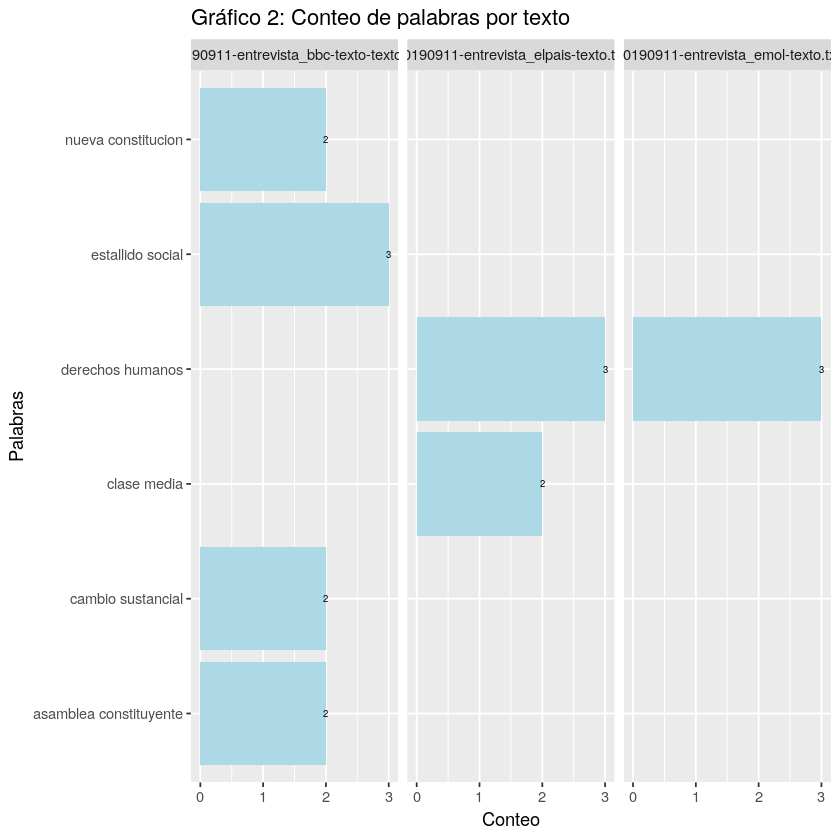

In [24]:
ngram_t %>%
    count(source, ngram) %>%
    group_by(source) %>%
    filter(n >1) %>%
    ggplot(aes(x = ngram, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    geom_text(size = 2) + 
    facet_wrap(~ source) +
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip() +
    ggtitle("Gráfico 2: Conteo de palabras por texto")

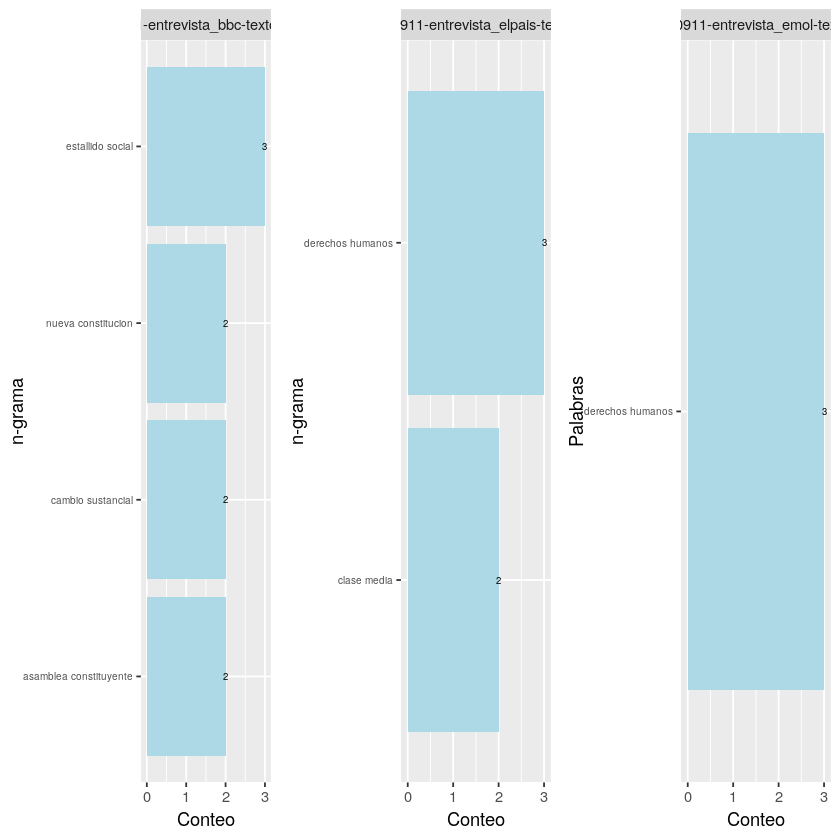

In [28]:
p1 <- ngram_1 %>%
    count(source, ngram) %>%
    filter(n > 1) %>%
    mutate(ngram = reorder(ngram, n)) %>%
    ggplot(aes(x = ngram, y = n, label = n)) +
    geom_col(fill = "lightblue") +
    theme(axis.text.y = element_text(size = 6)) + 
    geom_text(size = 2) +
    facet_wrap(~source) +
    xlab("n-grama") +
    ylab("Conteo") +
    coord_flip()

p2 <- ngram_2 %>%
    count(source, ngram) %>%
    filter(n > 1) %>%
    mutate(ngram = reorder(ngram, n)) %>%
    ggplot(aes(x = ngram, y = n, label = n)) +
    theme(axis.text.y = element_text(size = 6)) + 
    geom_col(fill = "lightblue") +
    geom_text(size = 2) +
    facet_wrap(~source) +
    xlab("n-grama") +
    ylab("Conteo") +
    coord_flip()

p3 <- ngram_3 %>%
    count(source, ngram) %>%
    filter(n > 1) %>%
    mutate(ngram = reorder(ngram, n)) %>%
    ggplot(aes(x = ngram, y = n, label = n)) +
    theme(axis.text.y = element_text(size = 6)) + 
    geom_col(fill = "lightblue") +
    geom_text(size = 2) +
    facet_wrap(~source) +
    xlab("Palabras") +
    ylab("Conteo") +
    coord_flip()

multiplot(p1, p2, p3, cols = 3)

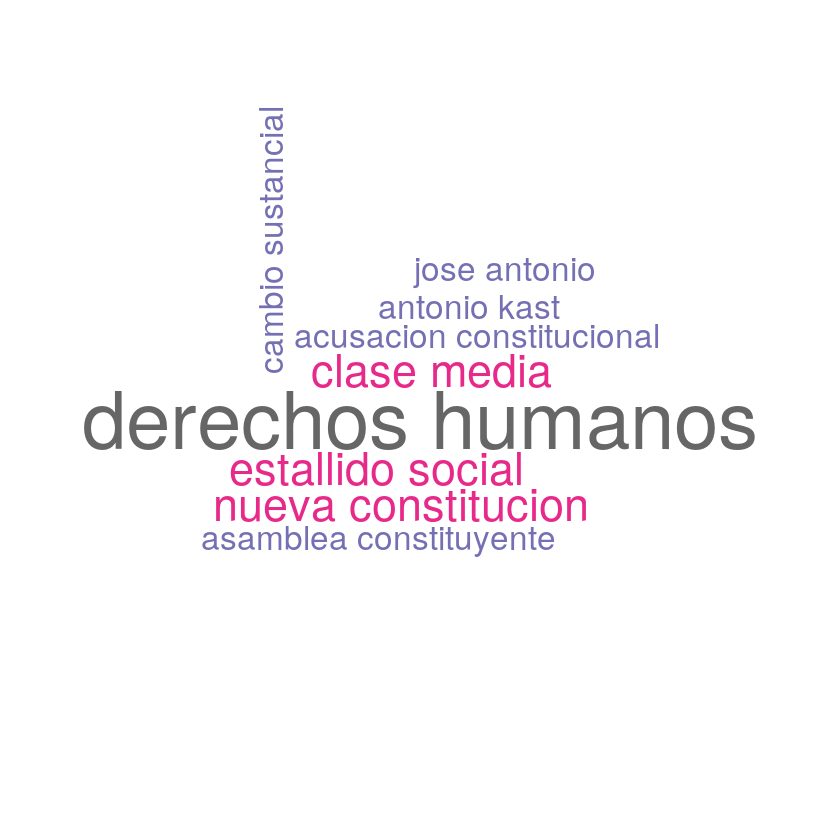

In [26]:
ngram_t %>%
    count(ngram) %>%
    mutate(ngram = reorder(ngram, n)) %>%
    with(wordcloud(words = ngram, freq = n, min.freq = 2, random.order = FALSE, colors = brewer.pal(8, "Dark2")))